# US CPI and Fed Funds Effective Rate
This notebook jaxteposes the evolution of US seasonally adjusted CPI with Fed Funds Effective Rate. Most of the time the Fed Funds rate has been slightly above the CPI.

In [1]:
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.fromisoformat('2022-07-01')

### Get Consumer Price Index for All Urban Consumers and Fed Funds Effective Rate from St. Luis Fed Economic Data

In [3]:
fred_cpi_ffr = web.get_data_fred(['CPIAUCSL', 'FEDFUNDS'], start=report_start, end=report_end)

In [4]:
# Since CPIAUCSL is indexed to 1982-1984=100, we need to convert it to annual percentage changes
fred_cpi_ffr.update(fred_cpi_ffr['CPIAUCSL'].pct_change(12)*100)
fred_cpi_ffr = fred_cpi_ffr.loc['1970':]
fred_cpi_ffr.rename(
    columns={'CPIAUCSL': 'Annual seasonaly adjusted CPI', 'FEDFUNDS': 'Federal Funds Effective Rate'},
    inplace=True)
fred_cpi_ffr

,Annual seasonaly adjusted CPI,Federal Funds Effective Rate
DATE,,
1970-01-01,6.162465,8.98
1970-02-01,6.424581,8.98
1970-03-01,6.094183,7.76
1970-04-01,6.060606,8.10
1970-05-01,6.043956,7.95
...,...,...
2022-02-01,7.912024,0.08
2022-03-01,8.557586,0.20
2022-04-01,8.224139,0.33


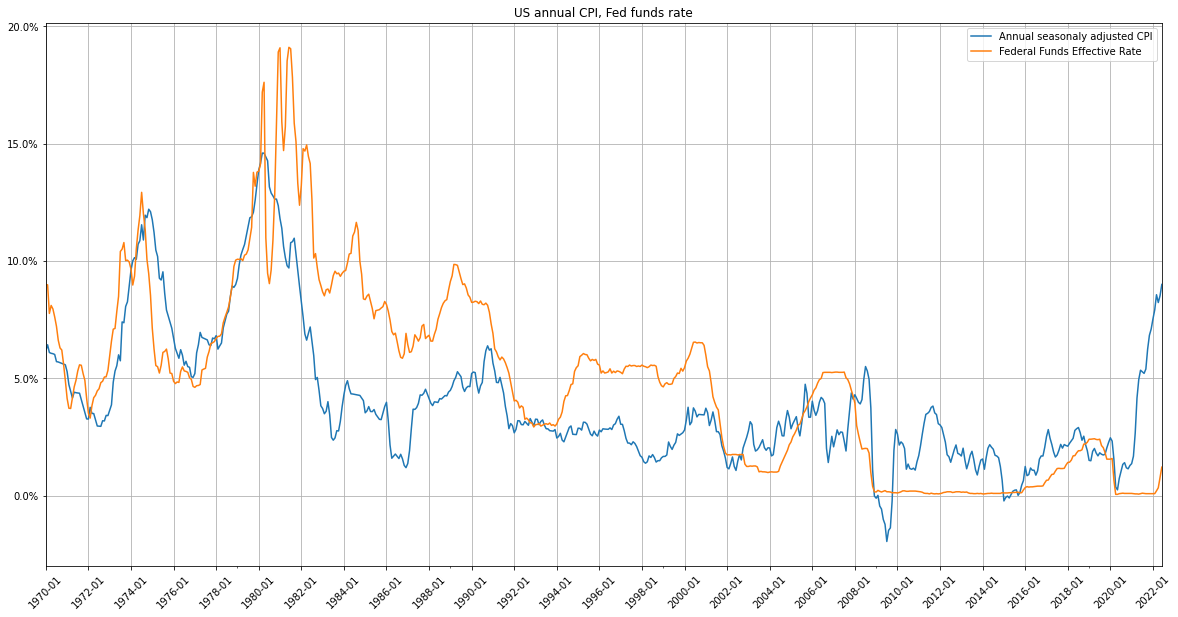

In [5]:
ax = fred_cpi_ffr.plot(figsize=(20,10), grid=True, title='US annual CPI, Fed funds rate',
                       xticks=fred_cpi_ffr.index[::24], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), fred_cpi_ffr.index[::24])))